In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
datos=np.load('test_line.npy')
datos

array([[ 0.00000000e+00,  1.42857143e-01,  2.85714286e-01,
         4.28571429e-01,  5.71428571e-01,  7.14285714e-01,
         8.57142857e-01,  1.00000000e+00,  1.14285714e+00,
         1.28571429e+00,  1.42857143e+00,  1.57142857e+00,
         1.71428571e+00,  1.85714286e+00,  2.00000000e+00],
       [ 1.96248739e+02,  2.17109545e+02,  2.02438147e+02,
         2.20817965e+02,  2.13819395e+02,  2.27251238e+02,
         2.17515781e+02,  2.21388623e+02,  2.36648800e+02,
         2.40642358e+02,  2.34123099e+02,  2.35261971e+02,
         2.50209093e+02,  2.63271434e+02,  2.74829289e+02],
       [ 1.76815884e+01, -5.03133689e+00,  1.65857792e+01,
         1.37444076e+01,  2.87670665e+00,  6.82112915e+00,
         7.36724007e+00,  3.03301838e+01,  4.29012660e+00,
         2.52042751e+01, -9.21174822e+00, -1.65378113e+00,
        -6.43187287e+00,  1.12999903e+01,  2.35848953e+01]])

In [56]:
n = 20 
m = 30 
b = 200 

Text(0, 0.5, 'y')

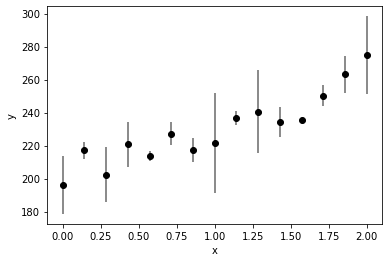

In [57]:
x=datos[0]
y=datos[1]
y_err=np.absolute(datos[2])

datastyle = dict(linestyle='none', marker='o', color='k', ecolor='#666666')
plt.errorbar(x, y, y_err,**datastyle)
plt.xlabel('x')
plt.ylabel('y')

In [59]:
#Definimos una función que evalue un modelo de linea recta en los valores x
# la variabele pars contiene los valores de los parametros m, b de la recta
def LineaRecta(pars, x):
    return pars[0]*np.array(x) + pars[1]

In [61]:
class ModeloLineaRecta(object):
    
    def __init__(self, x, y, y_err):
        self.x = np.asarray(x)
        self.y = np.asarray(y)
        self.y_err = np.asarray(y_err)

    def ln_likelihood(self, pars):
        N = len(self.y)
        
        #dy es la diferencia entre entre los datos exp. y los datos teóricos
        dy = self.y - LineaRecta(pars, self.x)
        # ivar es 1/varianza
        ivar = 1 / self.y_err**2 
        return -0.5 * (N*np.log(2*np.pi) + np.sum(2*np.log(self.y_err)) + np.sum(dy**2 * ivar))

    def ln_prior(self, pars):
        # el prior depende solo de los parámetros, en este caso tendremos un prior plano cuyos parámetros son la pendiente
        # y la ordenada al origen del modelo de la linea recta
        m, b = pars
        ln_prior_val = 0. 

        if m < 0 or m > 100.:
            return -np.inf
        else:
            0.0

        if b < 190 or b > 250:
            return -np.inf
        else:
            0.0
        return 0.0
    

    def ln_posterior(self, pars):
        # el log del posterior es la suma del log prior más el log likelihood
        lnp = self.ln_prior(pars)        
        lnL = self.ln_likelihood(pars)
        lnprob = lnp + lnL

        return lnprob
    
    def __call__(self, pars):
        return self.ln_posterior(pars)

modelo = ModeloLineaRecta(x, y, y_err)

In [62]:
def sample_proposal(*sigmas):
    return np.random.normal(0., sigmas)

#definimos una función que genere samples de la funcion log-posterior partiendo los parametros iniciales.

def MCMC(p_init, N_iter, modelo, proposal_sigmas):
 
    #proposal_sigmas es una lista de desviaciones estandar pasadas a la funcion sample_proposal
    
    #p_init contiene inf. sobre los parametros iniciales m, b
    p_init = np.array(p_init)
    
    #N_iter es el numero de iteraciones 
    # chain es un objeto que será llenado con los valores de los parametros en cada iteracion
    chain = np.zeros((N_iter, len(p_init)))
    # ln_probs es un objeto que será llenado con los valores de log-probability en cada iteración
    ln_probs = np.zeros(N_iter) 
    
    # esta variable sirve para calcular la fraccion de aceptación
    n_accept = 0 
    
    # aquí evaluamos el log del posterior en el punto inicial y almacenamos ese valor en el elemento 0 de chain
    ln_probs[0] = modelo(p_init)
    chain[0] = p_init
    
    # loop sobre el número de iteraciones 
    for i in range(1,N_iter):
        # proponemos un nuevo punto aleatorio
        step = sample_proposal(*proposal_sigmas)
        new_p = chain[i-1] + step
        
        # compute log-posterior at new parameter values
        new_ln_prob = modelo(new_p)
        
        # log of the ratio of the new log-posterior to the previous log-posterior value
        ln_prob_ratio = new_ln_prob - ln_probs[i-1]
        
        if (ln_prob_ratio > 0) or (ln_prob_ratio > np.log(np.random.uniform(0,1))):
            chain[i] = new_p
            ln_probs[i] = new_ln_prob
            n_accept += 1
            
        else:
            chain[i] = chain[i-1]
            ln_probs[i] = ln_probs[i-1]
    
    acc_frac = n_accept / N_iter
    print("El nuevo punto es: ",new_p)
    
    return chain, ln_probs, acc_frac
 

In [65]:
p_init = [35,210]
chain,_,acc_frac = MCMC(p_init, N_iter=10000, modelo=modelo, proposal_sigmas=[0.05,0.05])
print("Acceptance fraction: {:.1%}".format(acc_frac))

El nuevo punto es:  [ 19.68017486 205.50799073]
Acceptance fraction: 94.9%


Text(0, 0.5, '$b$')

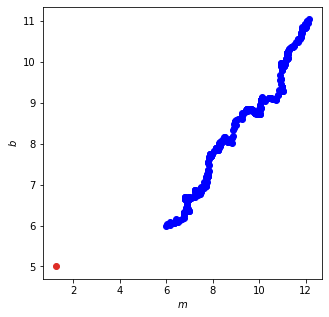

In [40]:
fig,ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(m, b, marker='o', zorder=10, color='#de2d26')
#ax.plot(chain[:512,0], chain[:512,1], marker='', color='k', linewidth=1.)

plt.scatter(chain[:400,0], chain[:400,1], c='b')
ax.set_xlabel('$m$')
ax.set_ylabel('$b$')